<a href="https://colab.research.google.com/github/robervz22/Proyecto-Final-Series-de-Tiempo-2023/blob/main/VAR_Cointegracion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spurious Regression

---



Example to movitate the study of cointegrated systems


In [ ]:
install.packages('latex2exp')
install.packages('lmtest')
install.packages('patchwork')

In [17]:
rm(list=ls())
library(data.table)
library(latex2exp)
library(tidyr)
library(ggplot2)
library(patchwork)
library(lmtest)
library(dplyr)

In [18]:
# ggplot2 theme
mysize <- 12
mytheme <- theme_bw() + # bw theme
  theme(
    axis.title = element_text(size=mysize, face="bold"),
    axis.text = element_text(size=mysize,face = "bold"),
    legend.title = element_text(size=mysize,face="bold"),
    legend.text = element_text(size=mysize),
    legend.position = "bottom",
    plot.title=element_text(hjust=0.5,size=16, face = "bold"),
    plot.subtitle=element_text(hjust=0.5,size=14)
    ) # cambiamos algunos valores

In [19]:
# tamanio de los graficos
options(repr.plot.width = 12, repr.plot.height =8) # tamanio de los graficos



---

## Common trends

We show the effect of stochastic trends in time series.

In [20]:
set.seed(911)
DW <- c(); R_square <- c(); t_intercept <- c(); t_slope <- c()
n_sim<-500
for (i in 1:n_sim){
  X <- cumsum(rnorm(n=100))
  Y <- cumsum(rnorm(n=100))
  values<-summary(lm(Y~X))
  DW<-c(DW,dwtest(values,alternative = "two.sided")$statistic[[1]])
  R_square<-c(R_square,values$r.squared)
  t_intercept<-c(t_intercept,values$coefficients[,"t value"][[1]])
  t_slope<-c(t_slope,values$coefficients[,"t value"][[2]])
}


We build a data.table with the results

In [21]:
dt_reg_spu <- data.table(x=c(1:n_sim),
                        t_intercept=t_intercept,
                        t_slope=t_slope,
                        R_square=R_square,
                        DW=DW)

dt_reg_spu_melt <- melt(dt_reg_spu,id.vars = "x",
                        measure.vars=c("t_intercept","t_slope","R_square","DW"),
                        variable.name=c("feature"),
                        value.name="value")
dt_reg_spu_melt[,x:=NULL]

Spurious regression visualisation

In [22]:
dt_reg_spu_melt_mod <- dt_reg_spu_melt %>%
  mutate(feature = recode(feature,
    "t_intercept" = "t[alpha]",
    "t_slope" = "t[beta]",
    "R_square" = "R^{2}",
    "DW" = "DW"
  ))

gg_reg_I1<- ggplot(dt_reg_spu_melt_mod,aes(x=value,group=feature))+
              geom_density(fill="#FF6666",alpha=0.2,)+
              facet_wrap(~feature,scales = "free",labeller = label_parsed)+
              labs(title=TeX(r"(Regresion between $Y_t$ and $X_t$)"),
              subtitle="")+mytheme

Now, we take differences and repeat

In [ ]:
set.seed(911)
DW <- c(); R_square <- c(); t_intercept <- c(); t_slope <- c()
n_sim<-500
for (i in 1:n_sim){
  X <- cumsum(rnorm(n=100))
  X <- diff(X)
  Y <- cumsum(rnorm(n=100))
  Y <- diff(Y)
  values<-summary(lm(Y~X))
  DW<-c(DW,dwtest(values,alternative = "two.sided")$statistic[[1]])
  R_square<-c(R_square,values$r.squared)
  t_intercept<-c(t_intercept,values$coefficients[,"t value"][[1]])
  t_slope<-c(t_slope,values$coefficients[,"t value"][[2]])
}

In [24]:
dt_reg_spu <- data.table(x=c(1:n_sim),
                        t_intercept=t_intercept,
                        t_slope=t_slope,
                        R_square=R_square,
                        DW=DW)

dt_reg_spu_melt <- melt(dt_reg_spu,id.vars = "x",
                        measure.vars=c("t_intercept","t_slope","R_square","DW"),
                        variable.name=c("feature"),
                        value.name="value")
dt_reg_spu_melt[,x:=NULL]

In [25]:
dt_reg_spu_melt_mod <- dt_reg_spu_melt %>%
  mutate(feature = recode(feature,
    "t_intercept" = "t[alpha]",
    "t_slope" = "t[beta]",
    "R_square" = "R^{2}",
    "DW" = "DW"
  ))

gg_reg_I0 <- ggplot(dt_reg_spu_melt_mod,aes(x=value,group=feature))+
              geom_density(fill="#FF6666",alpha=0.2,)+
              facet_wrap(~feature,scales = "free",labeller = label_parsed)+
              labs(title=TeX(r"(Regression results between $\Delta Y_t$ and $\Delta X_t$)"),
              subtitle="")+mytheme

The results are for the different simulations

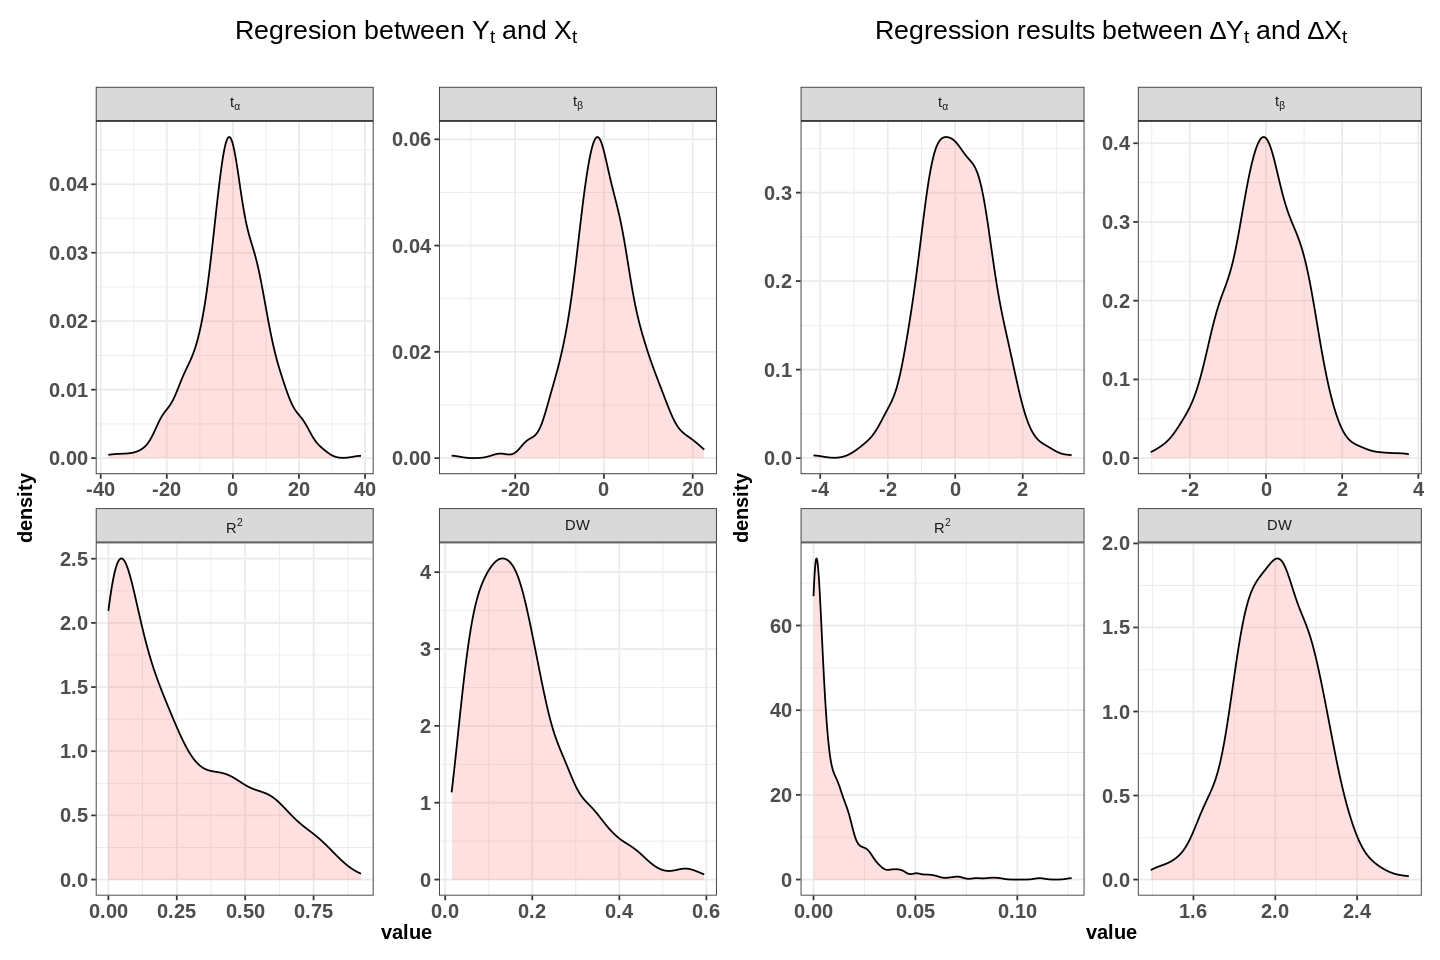

In [26]:
gg_reg_I1 + gg_reg_I0

Finally, an small example of cointegrated and independent processes

In [27]:
set.seed(1)
n=100
e_2<-rnorm(n)
v1 <- c(1:100)
v1[1]<-e_2[1]
for (i in 2:100){
    v1[i]=0.8*v1[i-1]+e_2[i]
}
v2 <- cumsum(e_2)

In [28]:
X <- cumsum(rnorm(n=100))
co_Y <- X+v1
Y <- X+v2

Grafica de los procesos

In [29]:
dt_co_process <- data.table(t=c(1:100),X=X,co_Y=co_Y,Y)

In [30]:
options(repr.plot.width = 10, repr.plot.height =6)

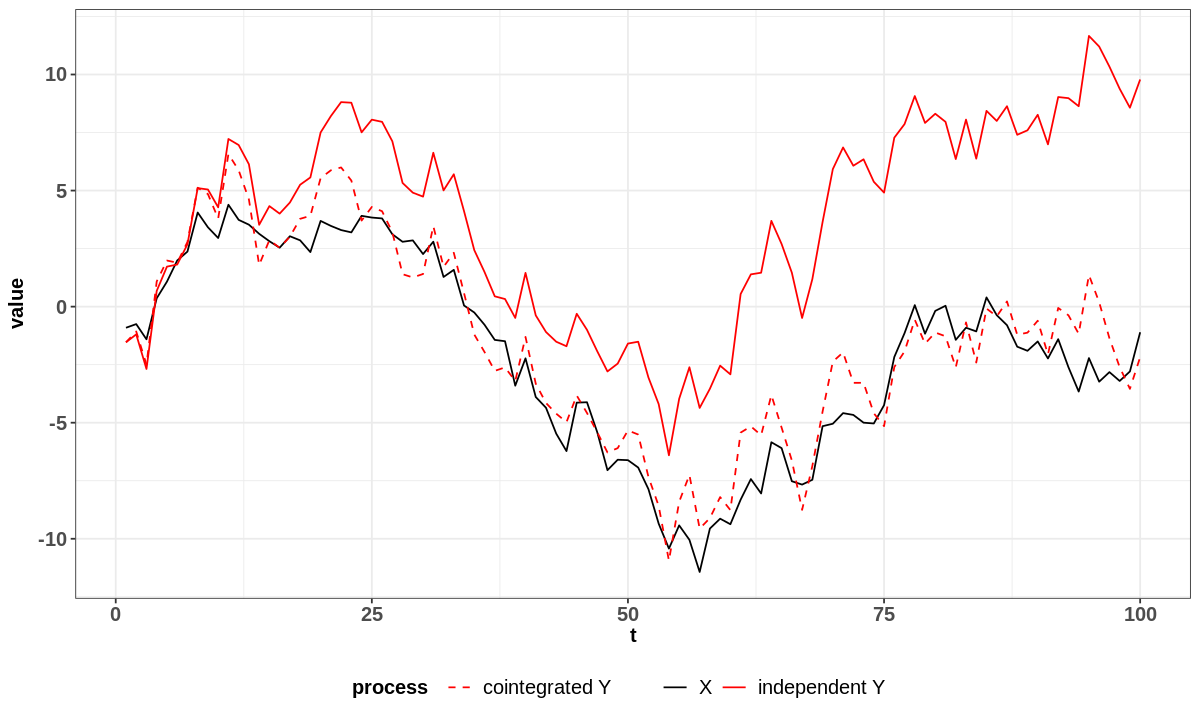

In [31]:
ggplot() +
  geom_line(data = dt_co_process, aes(x = t, y = X, color = "X", linetype = "X")) +
  geom_line(data = dt_co_process, aes(x = t, y = Y, color = "Y", linetype = "Y")) +
  geom_line(data = dt_co_process, aes(x = t, y = co_Y, color = "co_Y", linetype = "co_Y")) +
  scale_color_manual(
    name = "process",
    values = c("X" = "black", "Y" = "red", "co_Y" = "red"),
    labels = c("X" = "X", "Y" = "independent Y", "co_Y" = "cointegrated Y")
  ) +
  scale_linetype_manual(
    name = "process",
    values = c("X" = "solid", "Y" = "solid", "co_Y" = "dashed"),
    labels = c("X" = "X", "Y" = "independent Y", "co_Y" = "cointegrated Y")
  ) +
  labs(y = "value") +
  mytheme
